# MATH6380O Project3 Report on GANs and Evaluations
### Tianhan Wei, Shaopeng Guo, Zhou He

We have implemented various types of GAN modesl on Fashion MNIST dataset, trained a classifier on Fashion MNIST datset and used inception score and diversity score as metrics to evaluate the generation results.

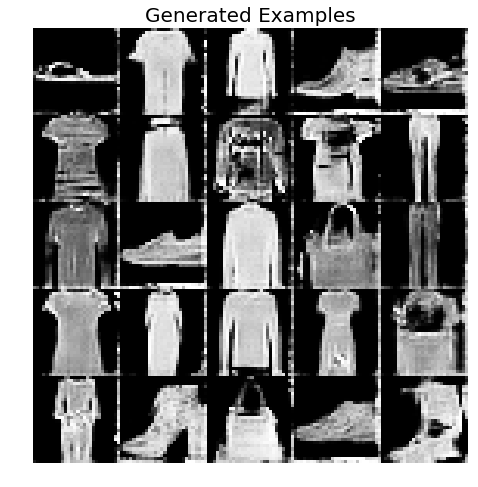

In [17]:
from figure import drawfig
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,8]

drawfig('wgan_gp_conv_val',title='Generated Examples')

## Part 1: Vanilla GAN, WGAN-GP with FC layer, and WGAN-GP with Convolutions

In [2]:
#We first take a look at the original data FMNIST.
import tensorflow as tf
import os
import itertools 
import random
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
fashion_mnist = input_data.read_data_sets('./fashion_mnist_data',
                                          source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')
print("Fashion MNIST data loaded.")

/home/samuel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting ./fashion_mnist_data/train-images-idx3-ubyte.gz
Extracting ./fashion_mnist_data/train-labels-idx1-ubyte.gz
Extracting ./fashion_mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./fashion_mnist_data/t10k-labels-idx1-ubyte.gz
Fashion MNIST data loaded.


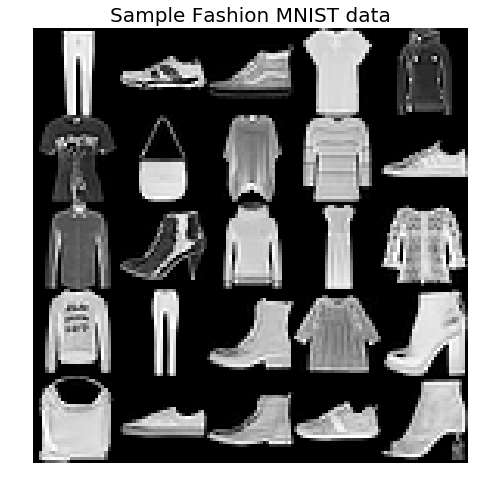

In [9]:
from figure import draw25imgs
view,_ = fashion_mnist.train.next_batch(25)
view = np.reshape(view,(-1,28,28)) * 255.0
#%matplotlib inline
#plt.rcParams['figure.figsize'] = [8,8]
draw25imgs(view)

### Implementation of three types of GAN models.
Their implementations are in vanilla_gan.py, wgan_gp_fclayers.py, wgan_gp_with_conv.py, respectively. The architecture and some technical specification used in these three models were:

#### Vanilla GAN
Generator:    
FC layer of 128 units, ReLU  
FC layer of 784 units, sigmoid  

Descriminator:    
FC layer of 128 units, ReLU 
FC layer of 1 unit, sigmoid 

The log-D trick was not used, nor did we scale the input image to [-1,1].

#### WGAN-GP with no convolution
Generator:  
FC layer of 128 units, ReLU  
FC layer of 784 units, tanh 

Descriminator:   
FC layer of 128 units, ReLU  
FC layer of 1 unit, no activation 



#### WGAN-GP with convolution operations
Generator:     
FC layer of 1024 units, ReLU  
BatchNorm 
FC layer of 6272 units, ReLU 
BatchNorm   
Resize to  7 x 7 x 128  
64 conv2d transpose filters of 4x4, stride 2, ReLU   
BatchNorm  
1 conv2d transpose filter of 4x4, stride 2, tanh   

Discriminator:    
64 Filters of 4x4, stride 2, LeakyReLU  
128 Filters of 4x4, stride 2, LeakyReLU  
BatchNorm  
Flatten   
FC layer of 1024 units, LeakyReLU  
FC Layer of 1 unit, no activation 

In both two WGAN-GP models, with or without convolution, the input images were all scaled to [-1,1], and that's why tanh activation was used in the last layer of the generator. When computing the loss of D, the weight of gradient penalty was set to 10, consistent with the original paper.



## Part 2: Functional Gradient Learning (Zhang et al., 2018)

## Part 3: Inception Score and Diversity Score

### Inception Score

In [10]:
# 1. inception score

from inception_score import Inception_Score
from scipy.misc import imread


In [11]:

def calculate_inception_score(results_dir, model_name):
    calculator = Inception_Score()
    all_images = []
    for sample_img in os.listdir(results_dir):
        img_path = os.path.join(results_dir,sample_img)
        img = imread(img_path)
        img = np.stack([img,img,img],axis=2)
        all_images.append(img)
    
    if len(all_images) >200:
        random.shuffle(all_images)
    
    mean, std = calculator.get_score(all_images[:200])
    print('The mean and std of the inception score of ' + model_name + ' results are,',mean, std)
        

In [12]:
# evaluate three models
vanilla_gan_results_dir = './vanillagan_val'
calculate_inception_score(vanilla_gan_results_dir, model_name = 'Vanilla GAN')
wgangp = './wgan_gp_val'
calculate_inception_score(wgangp, model_name='WGANGP with FC layers')
wgangpconv = './wgan_gp_conv_val'
calculate_inception_score(wgangpconv,model_name='WGANGP with Convolution layers')

/home/samuel/sources/GAN-and-Evaluations/inception_model/inception-2015-12-05.tgz
........................................................................................................................................................................................................The mean and std of the inception score of Vanilla GAN results are, 2.45221 0.323347
/home/samuel/sources/GAN-and-Evaluations/inception_model/inception-2015-12-05.tgz
........................................................................................................................................................................................................The mean and std of the inception score of WGANGP with FC layers results are, 2.74423 0.25182
/home/samuel/sources/GAN-and-Evaluations/inception_model/inception-2015-12-05.tgz
...............................................................................................................................................................................

In [59]:
sample_gt, _ = fashion_mnist.train.next_batch(200)
sample_gt = np.stack([sample_gt,sample_gt,sample_gt],axis=2)
samplegt = [ np.reshape(sample_gt[i],[28,28,3])*255 for i in range(200)]

print('The mean and std deviation of Inception score of ground truth is ' , calculator.get_score(samplegt))

........................................................................................................................................................................................................The mean and std deviation of Inception score of ground truth is  (3.3985939, 0.33438399)


From the calculation of the inception scores above, it could be concluded that the results produced by WGANGP-Conv has the closest inception scores with ground truth, followed WGANGP-FC, while Vanilla GAN has the lowest. This was consistent with our hypothesis because WGANGP model is good at stablizing the adversarial training, while using convolution in both generator and discriminator as DCGAN did can significantly enhance the quality of the images generated.

### MSSSIM Score
MS-SSIM score, or multi-scale structural similarity score, is calculated by averaging out a random 100 pairs of generated images of the same class (the class prediction is given by another pre-trained Fashion MNIST model which has achieved over 90% accuracy). A lower MS-SSIM score represents better diversity, which means that the generator model does not learn to memorize one 'safe answer' for each class.   
Our experiments below show that the results from all three models have rather high MS-SSIM scores, as in the case of training data. This indicate that neither the training data nor our generated result was very 'diverst'.

In [2]:
from classifier_test import test
from ms_ssim import MSSSIM_Calculator

In [3]:
def eval_classified_list(classified):
    msssimcal = MSSSIM_Calculator()
    model_msssim = []
    for oneclass in classified:
        allmsssim = []
        num_img_this_class = len(oneclass)
        if num_img_this_class >= 2:
            allpairs = list(itertools.permutations(list(range(num_img_this_class)), 2))
            random.shuffle(allpairs)
            if len(allpairs) > 100:
                allpairs = allpairs[:100]
            for pair in allpairs:
                img1 = oneclass[pair[0]]
                img2 = oneclass[pair[1]]
                allmsssim.append(msssimcal.get_score(img1,img2))
            class_avg_msssim = np.mean(allmsssim)
            print('The mean MSSSIM score of this class is',class_avg_msssim)
            model_msssim.append(class_avg_msssim)
    print("The overall MSSSIM of this model is ", np.mean(model_msssim))

In [4]:
def evaluate_model_diversity(result_dir):
    classified = test(image_dir=result_dir, pickle_name='test.pickle')
    eval_classified_list(classified)

In [5]:
evaluate_model_diversity('./wgan_gp_conv_val')

processing 50 / 1000
processing 100 / 1000
processing 150 / 1000
processing 200 / 1000
processing 250 / 1000
processing 300 / 1000
processing 350 / 1000
processing 400 / 1000
processing 450 / 1000
processing 500 / 1000
processing 550 / 1000
processing 600 / 1000
processing 650 / 1000
processing 700 / 1000
processing 750 / 1000
processing 800 / 1000
processing 850 / 1000
processing 900 / 1000
processing 950 / 1000
processing 1000 / 1000
The mean MSSSIM score of this class is 0.985397289421
The mean MSSSIM score of this class is 0.992530459371
The mean MSSSIM score of this class is 0.990473759418
The mean MSSSIM score of this class is 0.990084377089
The mean MSSSIM score of this class is 0.991874967724
The mean MSSSIM score of this class is 0.973071133403
The mean MSSSIM score of this class is 0.986361687722
The mean MSSSIM score of this class is 0.988324696641
The mean MSSSIM score of this class is 0.982687387154
The mean MSSSIM score of this class is 0.986057305839
The overall MSSSIM o

In [5]:
evaluate_model_diversity('./wgan_gp_val')
evaluate_model_diversity('./vanillagan_val')

processing 50 / 1000
processing 100 / 1000
processing 150 / 1000
processing 200 / 1000
processing 250 / 1000
processing 300 / 1000
processing 350 / 1000
processing 400 / 1000
processing 450 / 1000
processing 500 / 1000
processing 550 / 1000
processing 600 / 1000
processing 650 / 1000
processing 700 / 1000
processing 750 / 1000
processing 800 / 1000
processing 850 / 1000
processing 900 / 1000
processing 950 / 1000
processing 1000 / 1000
The mean MSSSIM score of this class is 0.98518334181
The mean MSSSIM score of this class is 0.989191925033
The mean MSSSIM score of this class is 0.981984510664
The mean MSSSIM score of this class is 0.983205112797
The mean MSSSIM score of this class is 0.986473978376
The mean MSSSIM score of this class is 0.967666644134
The mean MSSSIM score of this class is 0.981155968348
The mean MSSSIM score of this class is 0.975814035043
The mean MSSSIM score of this class is 0.976397946787
The mean MSSSIM score of this class is 0.984001478651
The overall MSSSIM of

In [7]:
gtimg, gtlabel = fashion_mnist.train.next_batch(1000)

In [17]:
classifiedgt = [[] for x in range(10)]
for i in range(gtimg.shape[0]):
    idx = gtlabel[i]
    classifiedgt[idx].append(np.reshape(gtimg[i],(28,28)))
eval_classified_list(classifiedgt)

The mean MSSSIM score of this class is 0.999508368498
The mean MSSSIM score of this class is 0.99990220703
The mean MSSSIM score of this class is 0.999271923887
The mean MSSSIM score of this class is 0.999752518057
The mean MSSSIM score of this class is 0.999499680669
The mean MSSSIM score of this class is 0.999784402581
The mean MSSSIM score of this class is 0.999350242808
The mean MSSSIM score of this class is 0.99984571259
The mean MSSSIM score of this class is 0.999086872265
The mean MSSSIM score of this class is 0.9997412152
The overall MSSSIM of this model is  0.999574314358
